<a href="https://colab.research.google.com/github/seokhee516/kaggle-practice/blob/main/study/%ED%83%80%EC%9E%90_OPS_%EB%AA%A8%EB%8D%B8%EB%A7%81_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. KBO 타자 OPS 예측
## 1.2. 탐색적 데이터 분석

- Description
2019년 타자들의 상반기 OPS를 예측하는 모델을 만들어 주세요. 2010년부터 1군 엔트리에 1번 이상 포함 되었던 타자들의 역대 정규시즌,
시범경기 성적 정보를 제공합니다(후반기 OPS 예측 대회는 전반기 종료 한 달 전 따로 오픈할 예정입니다)

OPS=출루율+장타력
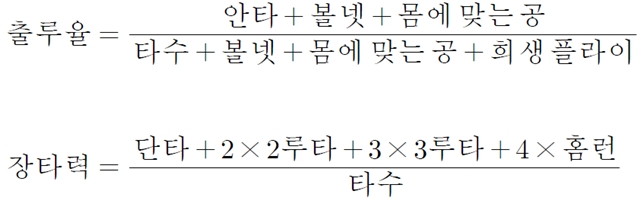

약 350명의 타자들의 시즌별 성적, 생년월일, 몸무게, 키 등의 정보가 제공됩니다.

* KBO기록실( https://www.koreabaseball.com/Record/Player/HitterBasic/Basic1.aspx )과 같은 법적인 제약이 없는 외부 데이터 사용이 가능합니다.

   

[Files]
①    Regular_Season_Batter.csv : KBO에서 활약한 타자들의 역대 정규시즌 성적을 포함하여 몸무게, 키 ,생년월일 등의 기본정보
②    Regular_Season_Batter_Day_by_Day.csv: KBO에서 활약한 타자들의 일자 별 정규시즌 성적
③    Pre_Season_Batter.csv : KBO에서 활약한 타자들의 역대 시범경기(정규시즌 직전에 여는 연습경기) 성적
④    submission.csv : 참가자들이 예측해야 할 타자의 이름과 아이디 목록

In [1]:
# 필요 라이브러리 로드
from matplotlib import font_manager, rc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import platform

if platform.system() == 'Windows':
# 윈도우인 경우 맑은 고딕 폰트 이용
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf"
                                           ).get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')

#그래프에서 마이너스 기호가 표시되게 하는 설정입니다.
matplotlib.rcParams['axes.unicode_minus'] = False

In [7]:
# 프리시즌 데이터 로드
preseason_df = pd.read_csv("Pre_Season_Batter.csv")
# 정규시즌 데이터 로드
regular_season_df = pd.read_csv("Regular_Season_Batter.csv")
# 데이터 크기 확인
print(preseason_df.shape)
# 데이터 상단 출력
display(preseason_df.head())

(1393, 29)


,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
0,0,가르시아,2018,LG,0.350,7,20,1,7,1,0,1,11,5,0,0,2,0,3,1,0.550,0.409,1,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.959
1,1,강경학,2011,한화,0.000,4,2,2,0,0,0,0,0,1,0,1,0,2,1,0,0.000,0.500,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.500
2,1,강경학,2014,한화,-,4,0,2,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,NaN
3,1,강경학,2015,한화,0.130,10,23,3,3,0,0,0,3,1,3,0,4,1,9,0,0.130,0.286,2,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.416
4,1,강경학,2016,한화,0.188,14,32,4,6,1,1,0,9,2,1,2,0,1,10,0,0.281,0.212,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.493


In [8]:
# 데이터 기초통계량 확인
display(preseason_df.describe())

,batter_id,year,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,OPS
count,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1364.000000,1368.000000,1393.000000,1364.000000
mean,173.434314,2013.014358,8.705671,19.201723,2.679828,5.021536,0.954774,0.119885,0.391960,7.391960,2.430725,0.629576,0.291457,1.877961,0.330223,3.714286,0.447236,0.361012,0.317912,0.381910,0.676924
std,94.716851,4.166757,5.562686,13.395946,2.637212,4.232584,1.196904,0.379976,0.748557,6.538787,2.698122,1.146854,0.595522,2.053392,0.642204,3.180884,0.723364,0.269892,0.151489,0.729521,0.386933
min,0.000000,2002.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,99.000000,2010.000000,6.000000,9.000000,1.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.217000,0.250000,0.000000,0.472000
50%,178.000000,2014.000000,9.000000,18.000000,2.000000,4.000000,1.000000,0.000000,0.000000,6.000000,2.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.344500,0.333000,0.000000,0.675000
75%,254.000000,2017.000000,11.000000,28.000000,4.000000,8.000000,2.000000,0.000000,1.000000,11.000000,4.000000,1.000000,0.000000,3.000000,1.000000,5.000000,1.000000,0.478000,0.400000,1.000000,0.867000
max,344.000000,2018.000000,119.000000,183.000000,35.000000,51.000000,11.000000,4.000000,5.000000,68.000000,24.000000,9.000000,4.000000,21.000000,4.000000,36.000000,5.000000,4.000000,1.000000,5.000000,5.000000


findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


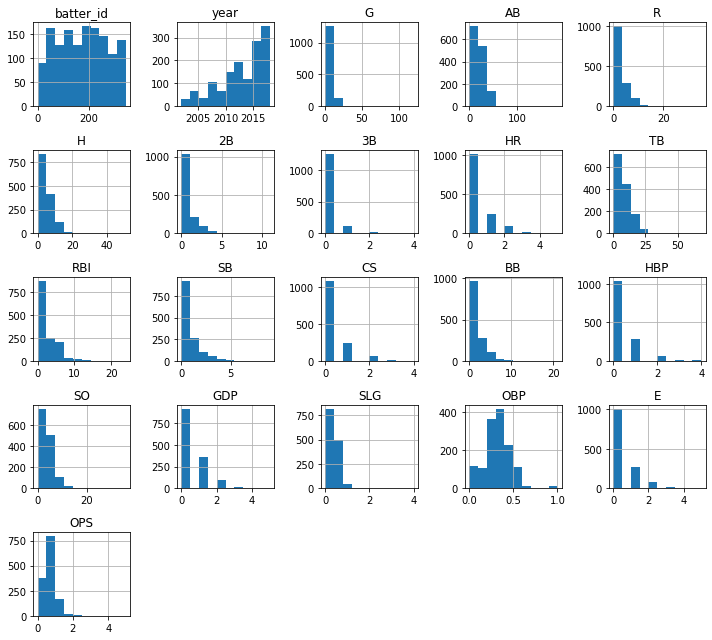

In [9]:
# 데이터 시각화
preseason_df.hist(figsize=(10,9))
plt.tight_layout() # 그래프 간격 설정
plt.show()

In [11]:
# 정규시즌 데이터에서 2002년 이후의 연도별 기록된 선수의 수
regular_count = regular_season_df.groupby('year')['batter_id'].count().rename('regular')
# 프리시즌 데이터에서 연도별 기록된 선수의 수
preseason_count = preseason_df.groupby('year')['batter_id'].count().rename('preseason')

In [13]:
pd.concat([regular_count,preseason_count, np.round(preseason_count/regular_count,2).rename(
        'ratio')], axis = 1).transpose().loc[:,2002:] # 2002년부터 봅니다. # 프리시즌 데이터 2002년 부터 존재

year,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
regular,43.00,54.00,68.00,73.00,85.00,98.00,115.00,124.00,130.00,151.0,174.0,194.00,186.00,207.00,213.00,217.00,227.0
preseason,12.00,19.00,28.00,37.00,36.00,43.00,61.00,66.00,72.00,75.0,87.0,104.00,117.00,134.00,153.00,167.00,182.0
ratio,0.28,0.35,0.41,0.51,0.42,0.44,0.53,0.53,0.55,0.5,0.5,0.54,0.63,0.65,0.72,0.77,0.8


In [19]:
# 타자의 이름과 연도를 이용해 새로운 인덱스를 생성
regular_season_df['new_idx'] = regular_season_df['batter_name'] + \
                               regular_season_df['year'].apply(str)
preseason_df['new_idx'] = preseason_df['batter_name'] + preseason_df['year'].apply(str)

In [26]:
# 방법 : set intersection 사용 교집합
# 새로운 인덱스의 교집합
intersection_idx = list(set(regular_season_df['new_idx']). \
                        intersection(preseason_df['new_idx']))

In [35]:
# 교집합에 존재하는 데이터만 불러오기
# 원래 regular_season_df는 2454개 row 존재
regular_season_new = regular_season_df.loc[
    regular_season_df['new_idx'].apply(lambda x: x in intersection_idx)].copy()
regular_season_new = regular_season_new.sort_values(by = 'new_idx').reset_index(drop=True) 

In [38]:
# 비교를 위해 인덱스로 정렬
preseason_new = preseason_df.loc[preseason_df['new_idx'].apply(
    lambda x: x in intersection_idx)].copy()
preseason_new = preseason_new.sort_values(by = 'new_idx').reset_index(drop=True)

In [40]:
# 검정 코드
print(regular_season_new.shape, preseason_new.shape)
sum(regular_season_new['new_idx'] == preseason_new['new_idx'])

(1358, 30) (1358, 30)


1358

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=fl

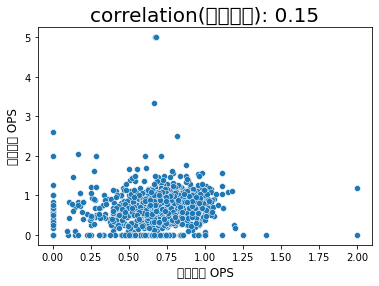

In [43]:
# 정규시즌과 프리시즌의 상관관계 계산
correlation = regular_season_new['OPS'].corr(preseason_new['OPS'])
sns.scatterplot(regular_season_new['OPS'], preseason_new['OPS']);
plt.title('correlation(상관계수): '+str(np.round(correlation,2)), fontsize=20)
plt.xlabel("정규시즌 OPS",fontsize=12)
plt.ylabel("프리시즌 OPS",fontsize=12)
plt.show();

### 1.2.2. 정규시즌 데이터 분석

In [44]:
# 방법 : display 사용 한번에 표시
regular_season_df = pd.read_csv("Regular_Season_Batter.csv")
display(regular_season_df.shape, regular_season_df.head(),regular_season_df.describe())

(2454, 29)

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,0,8,95,34,5,0,9,8,25,3,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902
1,1,강경학,2011,한화,0.000,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000
2,1,강경학,2014,한화,0.221,41,86,11,19,2,3,1,30,7,0,0,13,2,28,1,0.349,0.337,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.686
3,1,강경학,2015,한화,0.257,120,311,50,80,7,4,2,101,27,4,3,40,5,58,3,0.325,0.348,15,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.673
4,1,강경학,2016,한화,0.158,46,101,16,16,3,2,1,26,7,0,0,8,2,30,5,0.257,0.232,7,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.489


,batter_id,year,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,OPS
count,2454.000000,2454.000000,2428.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2428.000000,2430.000000,2454.000000,2428.000000
mean,178.079462,2011.614507,0.237559,72.535045,201.514670,29.912388,55.988183,9.863488,0.957620,5.504075,84.279136,27.788509,5.290139,2.335778,20.943765,3.424613,38.596985,4.603504,0.343826,0.306684,3.676447,0.649939
std,97.557947,4.992833,0.098440,45.093871,169.537029,28.778759,52.253844,9.871314,1.647193,7.989380,82.854200,29.602966,9.088580,3.194045,21.206113,4.132614,31.801466,4.713531,0.163335,0.111778,4.585248,0.261634
min,0.000000,1993.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,101.250000,2008.000000,0.203000,28.000000,38.250000,5.000000,8.000000,1.000000,0.000000,0.000000,10.000000,3.000000,0.000000,0.000000,3.000000,0.000000,10.000000,1.000000,0.267454,0.272727,0.000000,0.546000
50%,183.000000,2013.000000,0.255000,79.000000,163.000000,21.000000,40.000000,7.000000,0.000000,2.000000,56.000000,17.000000,2.000000,1.000000,14.000000,2.000000,33.000000,3.000000,0.360124,0.328592,2.000000,0.688637
75%,265.000000,2016.000000,0.291000,115.000000,357.500000,49.000000,100.000000,16.000000,1.000000,8.000000,146.000000,44.000000,6.000000,3.000000,34.000000,5.000000,60.000000,7.000000,0.436000,0.367000,5.000000,0.797234
max,344.000000,2018.000000,1.000000,144.000000,600.000000,135.000000,201.000000,47.000000,17.000000,53.000000,377.000000,146.000000,84.000000,21.000000,108.000000,27.000000,161.000000,24.000000,3.000000,1.000000,30.000000,4.000000


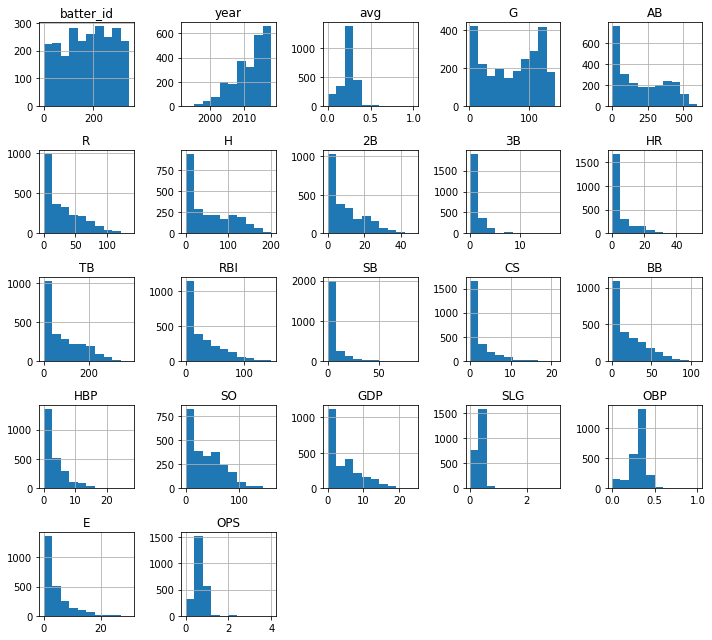

In [45]:
regular_season_df.hist(figsize=(10,9))
plt.tight_layout() # 그래프 간격 설정
plt.show()

연도별 OPS 중앙값 그래프

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50672 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_

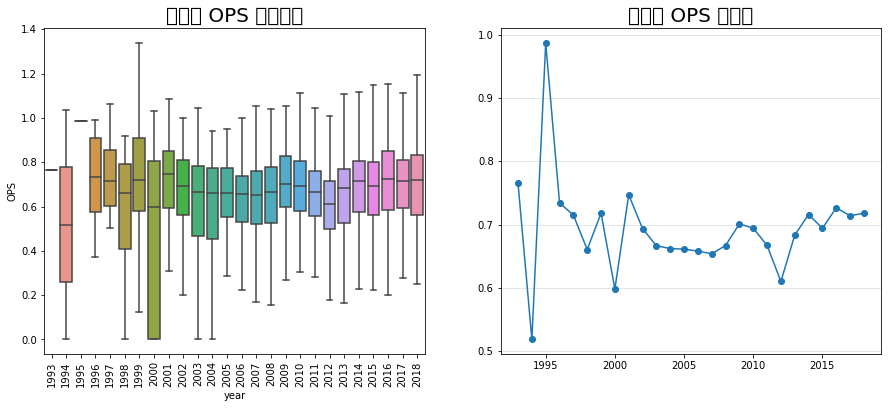

In [46]:
plt.figure(figsize=(15,6)) # 그래프 크기 조정
plt.subplot(1,2,1) # 1행 2열의 첫 번째(1행, 1열) 그래프
g = sns.boxplot(x="year", y="OPS", data=regular_season_df, showfliers=False)
g.set_title('연도별 OPS 상자그림', size = 20)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

plt.subplot(1,2,2)
plt.plot(regular_season_df.groupby('year')['OPS'].median(), marker='o')
plt.grid(axis='y', linestyle='-', alpha=0.4)
plt.title('연도별 OPS 중앙값', size = 20)
plt.show()

In [49]:
pd.crosstab(regular_season_df['year'],'count').T

year,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
col_0,,,,,,,,,,,,,,,,,,,,,,,,,,
count,1,2,1,7,8,10,14,20,32,43,54,68,73,85,98,115,124,130,151,174,194,186,207,213,217,227


In [50]:
 regular_season_df.pivot_table(index=['team'], columns='year',
                                             values='OPS', aggfunc='median')

year,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
team,,,,,,,,,,,,,,,,,,,,,,,,,,
KIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.849337,0.829906,0.681098,0.710473,0.583333,0.717176,0.546944,0.644474,0.707000,0.725000,0.680963,0.615420,0.679763,0.751196,0.598500,0.777000,0.777000,0.7320
KT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.643561,0.634500,0.710791,0.6550
LG,NaN,0.000000,NaN,0.476212,0.679836,0.509843,0.637173,0.689250,0.698978,0.645345,0.674368,0.594543,0.657000,0.593128,0.661500,0.622015,0.704000,0.677000,0.626000,0.552501,0.653000,0.680809,0.678000,0.729000,0.703000,0.7040
NC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.652500,0.636742,0.711000,0.703000,0.705000,0.6000
OB,NaN,NaN,NaN,NaN,0.615797,0.727667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.596491,0.393000,0.636000,0.494000,0.601000,0.682591,0.774000,0.693000,0.822977,0.689176,0.710000,0.666953,0.689636,0.751500,0.714000,0.798500,0.764796,0.7685
넥센,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.636166,0.623000,0.589000,0.671000,0.792032,0.753000,0.800500,0.743500,0.7650
두산,NaN,NaN,NaN,NaN,NaN,NaN,0.853830,0.739755,0.695808,0.762809,0.643209,0.672643,0.699575,0.639750,0.656000,0.702000,0.701938,0.780000,0.733000,0.660000,0.781500,0.702330,0.760000,0.763000,0.685000,0.8230
롯데,NaN,NaN,NaN,NaN,NaN,NaN,1.124961,0.453390,0.577847,0.577000,0.638655,0.662041,0.673000,0.586748,0.629000,0.725455,0.680000,0.653000,0.676715,0.581845,0.600000,0.689000,0.622000,0.704000,0.728000,0.7100


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50672 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54016 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46160 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49328 missing from current font.
  font.set_

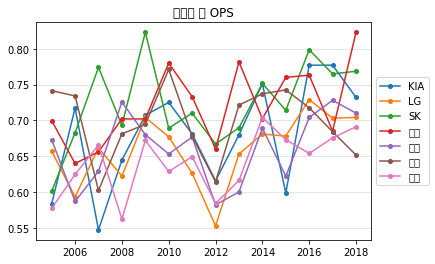

In [51]:
# 연도별 팀의 OPS 중앙값 계산
med_OPS_team = regular_season_df.pivot_table(index=['team'], columns='year',
                                             values='OPS', aggfunc='median')
# 2005년 이후에 결측치가 존재하지 않는 팀만 확인
team_idx = med_OPS_team.loc[:,2005:].isna().sum(axis=1) <= 0

plt.plot(med_OPS_team.loc[team_idx,2005:].T, marker = 'o', markersize=4)
plt.grid(axis='y', linestyle='-', alpha=0.4)
plt.legend(med_OPS_team.loc[team_idx,2005:].T.columns, 
           loc='center left', bbox_to_anchor=(1, 0.5)) # 그래프 범례를 그래프 밖에 위치
plt.title('연도별 팀 OPS')
plt.show()

In [54]:
# 의견 : re 정규표현식 사용
import re
regular_season_df['height/weight']

0       177cm/93kg
1       180cm/72kg
2       180cm/72kg
3       180cm/72kg
4       180cm/72kg
           ...    
2449    181cm/82kg
2450    181cm/82kg
2451    181cm/82kg
2452    181cm/82kg
2453    181cm/82kg
Name: height/weight, Length: 2454, dtype: object

In [55]:
regular_season_df['height/weight'].apply(
    lambda x: int(re.findall('\d+',x.split('/')[1])[0]) if pd.notnull(x) else x)

0       93.0
1       72.0
2       72.0
3       72.0
4       72.0
        ... 
2449    82.0
2450    82.0
2451    82.0
2452    82.0
2453    82.0
Name: height/weight, Length: 2454, dtype: float64

In [56]:
regular_season_df['weight'] = regular_season_df['height/weight'].apply(
    lambda x: int(re.findall('\d+',x.split('/')[1])[0]) if pd.notnull(x) else x)

regular_season_df['height'] = regular_season_df['height/weight'].apply(
    lambda x: int(re.findall('\d+',x.split('/')[0])[0]) if pd.notnull(x) else x)

print(regular_season_df['height/weight'][0], regular_season_df['height'][0],
      regular_season_df['weight'][0])

177cm/93kg 177.0 93.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47800 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47924 mi

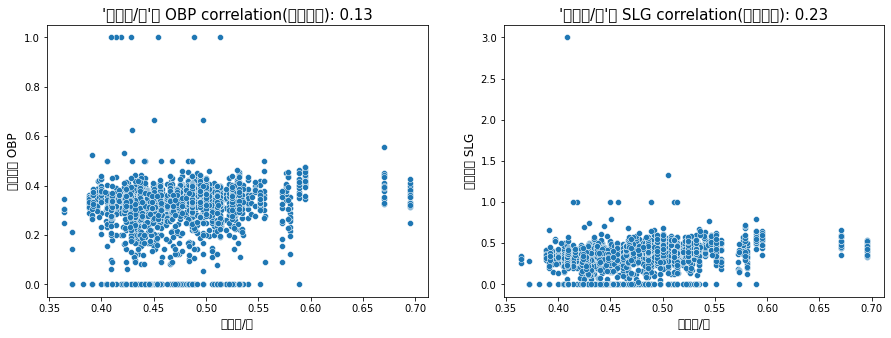

In [57]:
# 몸무게/키 계산
regular_season_df['weight_per_height'] = regular_season_df['weight'] / \
                                         regular_season_df['height']
plt.figure(figsize=(15, 5)) # 그래프 크기 조정
plt.subplot(1, 2, 1) # 1행 2열의 첫번째(1행, 1열) 그래프

# 정규시즌과 프리시즌의 상관관계 계산
correlation = regular_season_df['weight_per_height'].corr(regular_season_df['OBP'])
sns.scatterplot(regular_season_df['weight_per_height'], regular_season_df['OBP'])
plt.title("'몸무게/키'와 OBP correlation(상관관계): " + str(np.round(correlation, 2)), \
          fontsize=15)
plt.ylabel('정규시즌 OBP',fontsize=12)
plt.xlabel('몸무게/키', fontsize=12)
plt.subplot(1, 2, 2)

# 정규시즌과 프리시즌의 상관관계 계산
correlation = regular_season_df['weight_per_height'].corr(regular_season_df['SLG'])
sns.scatterplot(regular_season_df['weight_per_height'], regular_season_df['SLG'])
plt.title("'몸무게/키'와 SLG correlation(상관관계): " + str(np.round(correlation, 2)), \
          fontsize=15)
plt.ylabel('정규시즌 SLG', fontsize=12)
plt.xlabel('몸무게/키', fontsize=12)
plt.show()

SLG : 장타율


In [58]:
regular_season_df['position'].value_counts()

내야수(우투우타)    643
외야수(우투우타)    230
외야수(좌투좌타)    201
포수(우투우타)     189
외야수(우투좌타)    184
내야수(우투좌타)    141
내야수(좌투좌타)     36
포수(우투좌타)      14
내야수(우투양타)      7
외야수(우투양타)      7
Name: position, dtype: int64

In [59]:
# 의견 : split을 사용하여 문자열 정리 많음
# position
regular_season_df['pos']=regular_season_df['position'].apply(
    lambda x: x.split('(')[0] if pd.notnull(x) else x)

# 우타, 좌타, 양타
regular_season_df['hit_way'] = regular_season_df['position'].apply(
    lambda x: x[-3:-1] if pd.notnull(x) else x)
print(regular_season_df['position'][0], regular_season_df['pos'][0], 
      regular_season_df['hit_way'][0])

내야수(우투우타) 내야수 우타


In [65]:
# position 별 OPS 중앙값
medians = regular_season_df.groupby(['pos'])['OPS'].median().to_dict()
medians

{'내야수': 0.706, '외야수': 0.7190000000000001, '포수': 0.639}

In [64]:
# position별 관측치 수
nobs = regular_season_df['pos'].value_counts().to_dict()
nobs

{'내야수': 827, '외야수': 622, '포수': 203}

In [66]:
# 의견 : n의 형식으로 변환
for key in nobs: nobs[key] = "n: " + str(nobs[key])

In [67]:
nobs

{'내야수': 'n: 827', '외야수': 'n: 622', '포수': 'n: 203'}

In [68]:
# 타자 방향별 OPS 중앙값
medians = regular_season_df.groupby(['hit_way'])['OPS'].median().to_dict()
medians

{'양타': 0.63, '우타': 0.7, '좌타': 0.7130000000000001}

In [69]:
# 타자 방향 관측치 수
nobs = regular_season_df['hit_way'].value_counts().to_dict()
nobs

{'양타': 14, '우타': 1062, '좌타': 576}

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54252 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49496 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50556 missing from current font.
  font.set_

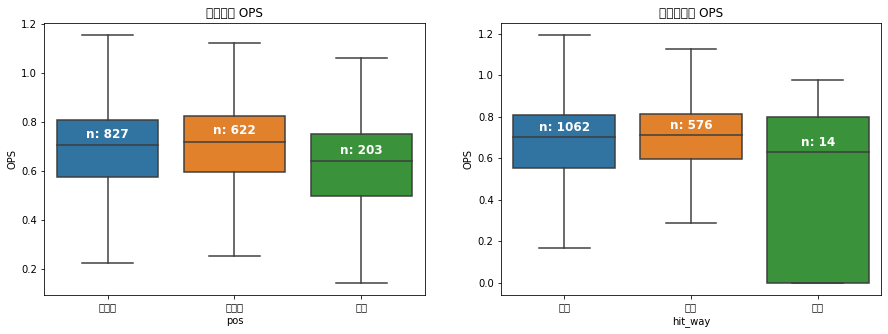

In [70]:
plt.figure(figsize=(15,5)) # 그래프 크기 조정
plt.subplot(1,2,1) # 1행 2열의 첫번째(1행, 1열) 그래프
ax = sns.boxplot(x='pos', y='OPS', data = regular_season_df, showfliers=False)

# position 별 OPS 중앙값
medians = regular_season_df.groupby(['pos'])['OPS'].median().to_dict()

# position별 관측치 수
nobs = regular_season_df['pos'].value_counts().to_dict()

# 키 값을 'n: 값' 형식으로 변환
for key in nobs: nobs[key] = "n: " + str(nobs[key])

# 그래프의 Xticks text 값 얻기
xticks_labels = [item.get_text() for item in ax.get_xticklabels()]

# tick은 tick의 위치, label은 그에 해당하는 text 값
for label in ax.get_xticklabels():
    ax.text(xticks_labels.index(label.get_text()), 
            medians[label.get_text()] + 0.03, nobs[label.get_text()],
            horizontalalignment='center', size='large', color='w', weight='semibold')
    
ax.set_title('포지션별 OPS')

plt.subplot(1,2,2) # 1행 2열의 두 번째(1행, 2열) 그래프
ax = sns.boxplot(x='hit_way', y='OPS', data = regular_season_df, showfliers=False)

# 타자 방향별 OPS 중앙값
medians = regular_season_df.groupby(['hit_way'])['OPS'].median().to_dict()
# 타자 방향 관측치 수
nobs = regular_season_df['hit_way'].value_counts().to_dict()
# 키 값을 'n: 값' 형식으로 변환
for key in nobs: nobs[key] = "n: " + str(nobs[key])

# 그래프의 Xticks text 값 얻기
xticks_labels = [item.get_text() for item in ax.get_xticklabels()]

# tick은 tick의 위치, label은 그에 해당하는 text 값
for label in ax.get_xticklabels():
    ax.text(xticks_labels.index(label.get_text()), medians[label.get_text()] + 0.03,
            nobs[label.get_text()], horizontalalignment='center', size='large',
            color='w', weight='semibold')
ax.set_title('타석방향별 OPS')

plt.show()

In [71]:
regular_season_df['career'].head()

0    쿠바 Ciego de Avila Maximo Gomez Baez(대)
1                         광주대성초-광주동성중-광주동성고
2                         광주대성초-광주동성중-광주동성고
3                         광주대성초-광주동성중-광주동성고
4                         광주대성초-광주동성중-광주동성고
Name: career, dtype: object

In [72]:
regular_season_df['career'].apply(
    lambda x: x.replace('-', ' ').split(' ')[0])

0          쿠바
1       광주대성초
2       광주대성초
3       광주대성초
4       광주대성초
        ...  
2449      석천초
2450      석천초
2451      석천초
2452      석천초
2453      석천초
Name: career, Length: 2454, dtype: object

In [73]:
# career를 split
foreign_country = regular_season_df['career'].apply(
    lambda x: x.replace('-', ' ').split(' ')[0])

# 외국만 추출
foreign_country_list = list(set(foreign_country.apply(
    lambda x: np.nan if '초' in x else x)))

# 결측치 처리
foreign_country_list = [x for x in foreign_country_list if str(x) != 'nan']
foreign_country_list

['도미니카', '쿠바', '네덜란드', '캐나다', '미국']

In [74]:
# 외국과 한국으로 구분
regular_season_df['country'] = foreign_country
regular_season_df['country'] = regular_season_df['country'].apply(
    lambda x: x if pd.isnull(x)
                 else ('foreign' if x in foreign_country_list else 'korean'))
regular_season_df[['country']].head()

,country
0,foreign
1,korean
2,korean
3,korean
4,korean


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51201 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44397 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51201 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text

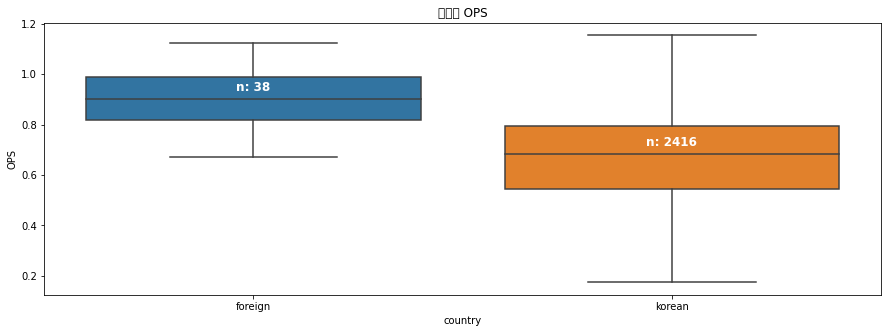

In [75]:
plt.figure(figsize=(15,5)) # 그래프 크기 조정
ax = sns.boxplot(x='country', y='OPS', data = regular_season_df, showfliers=False)

# 내외국인 별 OPS 중앙값 dict
medians = regular_season_df.groupby(['country'])['OPS'].median().to_dict()
# 내외국인 관측치 수 dict
nobs = regular_season_df['country'].value_counts().to_dict()
# 키 값을 'n: 값' 형식으로 변환 
for key in nobs: nobs[key] = "n: " + str(nobs[key])

# 그래프의 Xticks text 값 얻기
xticks_labels = [item.get_text() for item in ax.get_xticklabels()]
    
for label in ax.get_xticklabels(): # tick은 tick의 위치, label은 그에 해당하는 text 값 
    ax.text(xticks_labels.index(label.get_text()), medians[label.get_text()] + 0.03, \
            nobs[label.get_text()], # x 좌표, y 좌표, 해당 text
            horizontalalignment='center', size='large', color='w', weight='semibold') 
ax.set_title('국적별 OPS')
plt.show()

In [76]:
regular_season_df['starting_salary'].value_counts()

10000만원     177
6000만원      117
3000만원      105
9000만원       97
5000만원       91
8000만원       89
30000만원      74
4000만원       62
12000만원      62
18000만원      54
7000만원       53
11000만원      49
13000만원      48
20000만원      46
25000만원      45
15000만원      41
16000만원      28
14000만원      26
28000만원      20
43000만원      17
45000만원      16
27000만원      15
21000만원      13
23000만원      12
6500만원       10
33000만원      10
100000달러      4
300000달러      3
50000달러       2
17000만원       1
Name: starting_salary, dtype: int64

In [ ]:
# 방법 : 프로젝트 할 때 단위 통일 필요할 때 활용
# 결측치라면 그대로 0으로 두고 ‘만원’이 포함되어 있다면 숫자만 뽑아서 초봉으로 넣어준다. 
# 그외 만 원 단위가 아닌 초봉은 결측치로 처리한다.
regular_season_df['starting_salary'] = regular_season_df['starting_salary'].apply(
    lambda x: x if pd.isnull(x)
                 else(int(re.findall('\d+',x)[0]) if '만원' in x else np.nan))

plt.figure(figsize=(15,5)) # 그래프 크기 조정
plt.subplot(1,2,1) # 1행 2열의 첫 번째(1행, 1열) 그래프
b=sns.distplot(regular_season_df['starting_salary']. \
               loc[regular_season_df['starting_salary'].notnull()], hist=True)
b.set_xlabel("starting salary",fontsize=12)
b.set_title('초봉의 분포', fontsize=20)

plt.subplot(1,2,2) # 1행 2열의 두 번째(1행, 2열) 그래프

# 정규시즌과 프리시즌의 상관관계 계산
correlation = regular_season_df['starting_salary'].corr(regular_season_df['OPS'])
b = sns.scatterplot(regular_season_df['starting_salary'], regular_season_df['OPS'])
b.axes.set_title('correlation(상관계수): '+str(np.round(correlation,2)), fontsize=20)
b.set_ylabel("정규시즌 OPS",fontsize=12)
b.set_xlabel("초봉",fontsize=12)
plt.show()

### 1.2.3. 일별 데이터 분석

In [77]:
day_by_day_df = pd.read_csv(
    'Regular_Season_Batter_Day_by_Day_b4.csv')
display(day_by_day_df.shape, day_by_day_df.head())

(112273, 20)

,batter_id,batter_name,date,opposing_team,avg1,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,HBP,SO,GDP,avg2,year
0,0,가르시아,3.24,NC,0.333,3,1,1,0,0,0,0,0,0,1,0,1,0,0.333,2018
1,0,가르시아,3.25,NC,0.000,4,0,0,0,0,0,0,0,0,0,0,1,0,0.143,2018
2,0,가르시아,3.27,넥센,0.200,5,0,1,0,0,0,0,0,0,0,0,0,0,0.167,2018
3,0,가르시아,3.28,넥센,0.200,5,1,1,0,0,0,1,0,0,0,0,0,0,0.176,2018
4,0,가르시아,3.29,넥센,0.250,4,0,1,0,0,0,3,0,0,0,0,0,1,0.190,2018


- avg1 : 해당 경기 타율
- avg2 : 시즌 누적 타율


In [79]:
# 날짜(date)를 ‘.’을 기준으로 나누고 첫 번째 값을 월(month)로 지정 
day_by_day_df['month'] = day_by_day_df['date'].apply(lambda x: str(x).split('.')[0])

In [80]:
day_by_day_df.groupby(['year','month'])['avg2'].mean()

year  month
2001  10       0.356400
      4        0.205217
      5        0.297157
      6        0.306926
      7        0.293171
                 ...   
2018  5        0.274083
      6        0.280630
      7        0.280817
      8        0.283923
      9        0.277841
Name: avg2, Length: 134, dtype: float64

In [82]:
# 각 연도의 월별 평균 누적 타율(avg2) 계산
agg_df = day_by_day_df.groupby(['year','month'])['avg2'].mean().reset_index()

In [83]:
# 의견 : pivot 테이블의 좋은 점! 데이터 변형하여 분석 세밀화 가능
# pivot_table을 이용해 데이터 변형
agg_df = agg_df.pivot_table(index=['month'], columns='year', values = 'avg2')
agg_df

year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
month,,,,,,,,,,,,,,,,,,
10,0.356400,0.269065,0.216583,0.203636,NaN,0.260985,0.249888,0.249638,0.033333,NaN,0.243526,0.246949,0.257841,0.273537,0.274042,0.282547,0.280289,0.277482
3,NaN,NaN,NaN,NaN,NaN,0.261714,0.261714,0.271982,NaN,0.239861,NaN,NaN,0.231236,0.210598,0.214485,0.257857,0.161979,0.238015
4,0.205217,0.319792,0.250296,0.259663,0.235317,0.267106,0.215703,0.261531,0.252546,0.262953,0.247133,0.234199,0.267994,0.259918,0.255175,0.266711,0.259430,0.263953
5,0.297157,0.267990,0.241491,0.237954,0.253527,0.264283,0.237329,0.262535,0.280842,0.272934,0.250877,0.247844,0.268355,0.273899,0.261307,0.275240,0.274374,0.274083
6,0.306926,0.275867,0.252290,0.248800,0.249913,0.264392,0.260600,0.270766,0.278781,0.274791,0.263264,0.254577,0.270533,0.283480,0.268999,0.276307,0.279060,0.280630
7,0.293171,0.266650,0.244230,0.251973,0.256396,0.262464,0.259171,0.264870,0.275054,0.265501,0.264829,0.261513,0.262812,0.275677,0.272685,0.283192,0.284565,0.280817
8,0.303489,0.270481,0.252319,0.249460,0.243570,0.265369,0.270258,0.265173,0.271796,0.271075,0.262048,0.258069,0.268122,0.282025,0.272377,0.283105,0.283283,0.283923
9,0.308636,0.248333,0.243780,0.203953,0.237058,0.258794,0.251022,0.252942,0.264468,0.265312,0.258500,0.251232,0.260571,0.272411,0.271629,0.276513,0.273213,0.277841


연도별 월 평균타율

year,2011,2012,2013,2014,2015,2016,2017,2018
month,,,,,,,,
4,0.247133,0.234199,0.267994,0.259918,0.255175,0.266711,0.259430,0.263953
5,0.250877,0.247844,0.268355,0.273899,0.261307,0.275240,0.274374,0.274083
6,0.263264,0.254577,0.270533,0.283480,0.268999,0.276307,0.279060,0.280630
7,0.264829,0.261513,0.262812,0.275677,0.272685,0.283192,0.284565,0.280817
8,0.262048,0.258069,0.268122,0.282025,0.272377,0.283105,0.283283,0.283923
9,0.258500,0.251232,0.260571,0.272411,0.271629,0.276513,0.273213,0.277841


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50672 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_

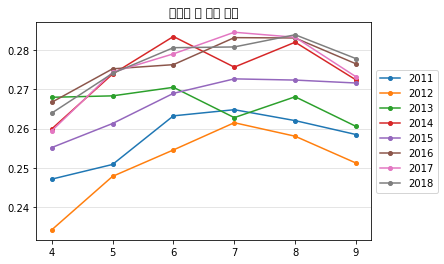

In [84]:
display(agg_df.iloc[2:, 10:])
plt.plot(agg_df.iloc[2:,10:], marker = 'o', markersize=4) # 2011~2018년 데이터만 이용
plt.grid(axis='y', linestyle='-', alpha=0.4)
plt.legend(agg_df.iloc[2:,10:].columns,
           loc='center left', bbox_to_anchor=(1, 0.5)) # 범례 그래프 밖에 위치
plt.title('연도별 월 평균 타율')
plt.show()

## 1.3. 데이터 전처리

In [85]:
# 결측값 확인
pd.DataFrame(regular_season_df.isna().sum()).transpose()

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,weight,height,weight_per_height,pos,hit_way,country
0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,24,0,802,0,802,0,1067,26,802,802,802,802,802,0


In [86]:
# 방법 : 수치형 타입 결측치 다루는 방법 -> 0으로 채우기
# 수치형 타입의 변수 저장
numerics = [
    'int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # 모든 numeric(수치형) 타입
num_cols = regular_season_df.select_dtypes(include=numerics).columns

In [87]:
# 수치형 타입 변수 중 결측치가 하나라도 존재하는 행 출력
# isna().sum(axis=1) -> 열 기준의 결측치 개수
# df.loc[]를 통해 결측치 0개 이상 데이터를 추출
regular_season_df.loc[regular_season_df[num_cols].isna().sum(axis=1) > 0,num_cols].head()

,batter_id,year,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,OPS,weight,height,weight_per_height
12,138,2005,0.127,39,63,9,8,2,0,0,10,3,1,2,7,4,15,1,0.158730,0.256757,3,0.415487,NaN,NaN,NaN
13,138,2006,0.139,37,36,6,5,2,0,0,7,0,1,0,8,2,14,0,0.194444,0.326087,4,0.520531,NaN,NaN,NaN
14,138,2007,0.000,8,4,3,0,0,0,0,0,0,0,0,0,0,2,1,0.000000,0.000000,0,0.000000,NaN,NaN,NaN
15,138,2008,0.000,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0,0.000000,NaN,NaN,NaN
16,138,2011,0.176,38,51,7,9,2,0,0,11,3,1,1,7,2,13,1,0.215686,0.300000,0,0.515686,NaN,NaN,NaN


In [88]:
# 방법 : include 사용
# 수치형 변수에 포함되는 데이터 타입 선정
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# 정규 시즌 데이터에서 결측치를 0으로 채우기
regular_season_df[regular_season_df.select_dtypes(include=numerics).columns] = \
    regular_season_df[regular_season_df.select_dtypes(include=numerics).columns].fillna(0)
regular_season_df

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,weight,height,weight_per_height,pos,hit_way,country
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,0,8,95,34,5,0,9,8,25,3,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902,93.0,177.0,0.525424,내야수,우타,foreign
1,1,강경학,2011,한화,0.000,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000,72.0,180.0,0.400000,내야수,좌타,korean
2,1,강경학,2014,한화,0.221,41,86,11,19,2,3,1,30,7,0,0,13,2,28,1,0.349,0.337,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.686,72.0,180.0,0.400000,내야수,좌타,korean
3,1,강경학,2015,한화,0.257,120,311,50,80,7,4,2,101,27,4,3,40,5,58,3,0.325,0.348,15,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.673,72.0,180.0,0.400000,내야수,좌타,korean
4,1,강경학,2016,한화,0.158,46,101,16,16,3,2,1,26,7,0,0,8,2,30,5,0.257,0.232,7,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.489,72.0,180.0,0.400000,내야수,좌타,korean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2449,344,황진수,2014,롯데,0.000,5,5,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000만원,0.000,82.0,181.0,0.453039,내야수,양타,korean
2450,344,황진수,2015,롯데,0.000,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000만원,0.000,82.0,181.0,0.453039,내야수,양타,korean
2451,344,황진수,2016,롯데,0.000,11,10,2,0,0,0,0,0,0,0,1,0,0,5,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000만원,0.000,82.0,181.0,0.453039,내야수,양타,korean
2452,344,황진수,2017,롯데,0.291,60,117,18,34,6,2,1,47,16,4,0,10,3,38,2,0.402,0.359,4,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000만원,0.761,82.0,181.0,0.453039,내야수,양타,korean


In [89]:
# 일별 데이터에서 결측치를 0으로 채우기
day_by_day_df[day_by_day_df.select_dtypes(include=numerics).columns] = \
    day_by_day_df[day_by_day_df.select_dtypes(include=numerics).columns].fillna(0)
day_by_day_df

,batter_id,batter_name,date,opposing_team,avg1,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,HBP,SO,GDP,avg2,year,month
0,0,가르시아,3.24,NC,0.333,3,1,1,0,0,0,0,0,0,1,0,1,0,0.333,2018,3
1,0,가르시아,3.25,NC,0.000,4,0,0,0,0,0,0,0,0,0,0,1,0,0.143,2018,3
2,0,가르시아,3.27,넥센,0.200,5,0,1,0,0,0,0,0,0,0,0,0,0,0.167,2018,3
3,0,가르시아,3.28,넥센,0.200,5,1,1,0,0,0,1,0,0,0,0,0,0,0.176,2018,3
4,0,가르시아,3.29,넥센,0.250,4,0,1,0,0,0,3,0,0,0,0,0,1,0.190,2018,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112268,344,황진수,6.23,LG,-,0,0,0,0,0,0,0,0,0,1,0,0,0,0.158,2018,6
112269,344,황진수,6.26,넥센,0.000,1,0,0,0,0,0,0,0,0,0,0,1,0,0.150,2018,6
112270,344,황진수,6.27,넥센,0.500,2,1,1,1,0,0,0,0,0,0,0,1,0,0.182,2018,6
112271,344,황진수,6.28,넥센,-,0,0,0,0,0,0,0,0,0,0,0,0,0,0.182,2018,6


In [90]:
# 프리시즌 데이터에서 결측치를 0으로 채우기
preseason_df[preseason_df.select_dtypes(include=numerics).columns] = \
    preseason_df[preseason_df.select_dtypes(include=numerics).columns].fillna(0)
preseason_df

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,new_idx
0,0,가르시아,2018,LG,0.350,7,20,1,7,1,0,1,11,5,0,0,2,0,3,1,0.550,0.409,1,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.959,가르시아2018
1,1,강경학,2011,한화,0.000,4,2,2,0,0,0,0,0,1,0,1,0,2,1,0,0.000,0.500,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.500,강경학2011
2,1,강경학,2014,한화,-,4,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000,강경학2014
3,1,강경학,2015,한화,0.130,10,23,3,3,0,0,0,3,1,3,0,4,1,9,0,0.130,0.286,2,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.416,강경학2015
4,1,강경학,2016,한화,0.188,14,32,4,6,1,1,0,9,2,1,2,0,1,10,0,0.281,0.212,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.493,강경학2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1388,342,황재균,2014,롯데,0.407,10,27,3,11,2,0,1,16,4,1,0,2,0,5,0,0.593,0.448,1,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,1.041,황재균2014
1389,342,황재균,2015,롯데,0.333,11,30,8,10,3,0,0,13,6,0,0,4,0,3,0,0.433,0.389,0,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.822,황재균2015
1390,342,황재균,2016,롯데,0.310,16,42,8,13,3,1,0,18,4,3,1,4,0,4,0,0.429,0.370,1,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.799,황재균2016
1391,342,황재균,2018,KT,0.250,6,16,3,4,1,0,1,8,4,0,0,2,0,6,0,0.500,0.333,3,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.833,황재균2018


In [91]:
# 수치형이 아닌 변수 추출 -> 삭제
not_num_cols = [x for x in regular_season_df.columns if x not in num_cols]

# 수치형이 아닌 변수 중 결측치가 하나라도 존재하는 행 출력
# isna().sum(axis=1) -> 열 기준의 결측치 개수
# df.loc[]를 통해 결측치 0개 이상 데이터를 추출
regular_season_df.loc[regular_season_df[not_num_cols].isna().sum(axis=1) > 0,
                      not_num_cols].head()

,batter_name,team,height/weight,year_born,position,career,starting_salary,pos,hit_way,country
0,가르시아,LG,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,내야수,우타,foreign
12,백승룡,한화,NaN,1982년 08월 16일,NaN,사직초(부산극동리틀)-사직중-경남상고-경성대-한화-넥센,NaN,NaN,NaN,korean
13,백승룡,한화,NaN,1982년 08월 16일,NaN,사직초(부산극동리틀)-사직중-경남상고-경성대-한화-넥센,NaN,NaN,NaN,korean
14,백승룡,한화,NaN,1982년 08월 16일,NaN,사직초(부산극동리틀)-사직중-경남상고-경성대-한화-넥센,NaN,NaN,NaN,korean
15,백승룡,한화,NaN,1982년 08월 16일,NaN,사직초(부산극동리틀)-사직중-경남상고-경성대-한화-넥센,NaN,NaN,NaN,korean


In [92]:
# 질문 : 왜 이러한 조건은 삭제하는지? 야구의 방식인가?
# 삭제할 데이터 추출
drop_idx = regular_season_df.loc[
    # 안타가 0개 이상이면서 장타율이 0인 경우
    ((regular_season_df['H'] > 0) & (regular_season_df['SLG']==0)) |
        
    # 안타가 0개 이상 혹은 볼넷이 0개 이상 혹은 몸에 맞은 볼이 0개 이상이면서
    # 출루율이 0인 경우
    (((regular_season_df['H'] > 0) |
      (regular_season_df['BB'] > 0) |
      (regular_season_df['HBP'] > 0)) &
     (regular_season_df['OBP'] == 0))
].index         

# 데이터 삭제
regular_season_df = regular_season_df.drop(drop_idx).reset_index(drop=True)
regular_season_df

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,weight,height,weight_per_height,pos,hit_way,country
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,0,8,95,34,5,0,9,8,25,3,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902,93.0,177.0,0.525424,내야수,우타,foreign
1,1,강경학,2011,한화,0.000,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000,72.0,180.0,0.400000,내야수,좌타,korean
2,1,강경학,2014,한화,0.221,41,86,11,19,2,3,1,30,7,0,0,13,2,28,1,0.349,0.337,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.686,72.0,180.0,0.400000,내야수,좌타,korean
3,1,강경학,2015,한화,0.257,120,311,50,80,7,4,2,101,27,4,3,40,5,58,3,0.325,0.348,15,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.673,72.0,180.0,0.400000,내야수,좌타,korean
4,1,강경학,2016,한화,0.158,46,101,16,16,3,2,1,26,7,0,0,8,2,30,5,0.257,0.232,7,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.489,72.0,180.0,0.400000,내야수,좌타,korean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442,344,황진수,2014,롯데,0.000,5,5,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000만원,0.000,82.0,181.0,0.453039,내야수,양타,korean
2443,344,황진수,2015,롯데,0.000,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000만원,0.000,82.0,181.0,0.453039,내야수,양타,korean
2444,344,황진수,2016,롯데,0.000,11,10,2,0,0,0,0,0,0,0,1,0,0,5,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000만원,0.000,82.0,181.0,0.453039,내야수,양타,korean
2445,344,황진수,2017,롯데,0.291,60,117,18,34,6,2,1,47,16,4,0,10,3,38,2,0.402,0.359,4,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000만원,0.761,82.0,181.0,0.453039,내야수,양타,korean


### 1.3.2. 규정 타수 정의

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


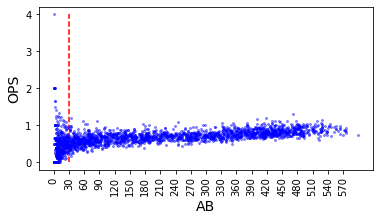

In [93]:
plt.figure(figsize=(6, 3)) # 크기 조정
plt.plot('AB', 'OPS', data=regular_season_df, linestyle='none', marker='o', 
         markersize=2, color='blue', alpha=0.4)
plt.xlabel('AB', fontsize=14)
plt.ylabel('OPS', fontsize=14)
plt.xticks(list(range(min(regular_season_df['AB']), max(regular_season_df['AB']), 30)),
           rotation=90)
plt.vlines(30,ymin=min(regular_season_df['OPS']),ymax=max(regular_season_df['OPS']),
           linestyles='dashed', colors='r')
plt.show()

AB : 해당 경기 타수

In [94]:
# OPS 이상치 탐색을 위한 수치 정의
# IQR = 데이터의 산포인 통계적 산포의 측도
Q1 = regular_season_df['OPS'].quantile(0.25)
Q3 = regular_season_df['OPS'].quantile(0.75)
IQR = Q3 - Q1

# 실제 OPS 이상치 탐색
regular_season_df.loc[(regular_season_df['OPS'] < (Q1 - 1.5 * IQR)) |
                      (regular_season_df['OPS'] > (Q3 + 1.5 * IQR))].sort_values(
    by=['AB'], axis=0, ascending=False)[['batter_name','AB','year','OPS']].head(10)

,batter_name,AB,year,OPS
2329,테임즈,472,2015,1.293656
97,강정호,418,2014,1.200156
1318,유재신,33,2018,1.192000
416,김원섭,25,2005,0.116923
1543,이여상,22,2013,0.090909
681,문규현,18,2007,0.109000
578,김회성,17,2010,0.105000
1902,정병곤,15,2018,0.130000
1874,정경운,15,2018,0.130000
2384,현재윤,15,2014,1.229167


7월 일별 경기수 합

In [95]:
# 방법 : 일별 데이터 그래프로 나타내는 방법
np.linspace(7.01,7.31, 31)

array([7.01, 7.02, 7.03, 7.04, 7.05, 7.06, 7.07, 7.08, 7.09, 7.1 , 7.11,
       7.12, 7.13, 7.14, 7.15, 7.16, 7.17, 7.18, 7.19, 7.2 , 7.21, 7.22,
       7.23, 7.24, 7.25, 7.26, 7.27, 7.28, 7.29, 7.3 , 7.31])

In [96]:
# 7.01~7.31 숫자 생성 후 반 올림
major_ticks = list(np.round(np.linspace(7.01,7.31, 31),2)) 

july = (day_by_day_df['date'] >= 7) & (day_by_day_df['date'] < 8) # 7월만 불러오는 index

In [98]:
day_by_day_df['date'].loc[july].value_counts()

7.29    703
7.08    684
7.26    668
7.28    667
7.31    645
7.27    634
7.10    596
7.05    576
7.22    570
7.12    567
7.21    562
7.30    561
7.07    557
7.11    541
7.03    537
7.04    537
7.06    535
7.13    522
7.09    510
7.19    500
7.01    499
7.24    499
7.20    466
7.25    466
7.02    429
7.23    422
7.18    391
7.14    360
7.17    336
7.16    302
7.15    282
Name: date, dtype: int64

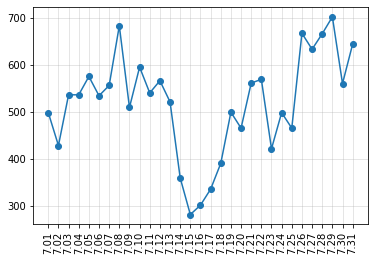

In [99]:
plt.plot(major_ticks,
         day_by_day_df['date'].loc[july].value_counts().sort_index(), marker='o')
plt.grid(linestyle='-', alpha=0.4)
plt.xticks(major_ticks,rotation=90)
plt.show()

### 1.3.3. 시간 변수

In [100]:
# 질문 : 뭔소리지...ㅠ
# 시간 변수를 생성하는 함수 정의
def lag_function(df, var_name, past):
    # df = 시간변수를 생성할 데이터 프레임
    # var_name = 시간변수 생성의 대상이 되는 변수 이름
    # past = 몇 년 전의 성적을 생성할지 결정 (정수형)
    df.reset_index(drop=True, inplace = True)
    
    #시간변수 생성
    df['lag'+str(past)+'_'+var_name] = np.nan;
    df['lag'+str(past)+'_'+'AB'] = np.nan
    
    for col in ['AB', var_name]:
        for i in range(0,(max(df.index)+1)):
            val = df.loc[(df['batter_name'] == df['batter_name'][i]) & 
                         (df['year'] == df['year'][i] - past), col]
            # 과거 기록이 결측치가 아니라면 값을 넣기
            if(len(val) != 0):
                df.loc[i, 'lag' + str(past) + '_' + col] = val.iloc[0]

    #30타수 미만 결측치 처리
    df.loc[df['lag' + str(past) + '_' + 'AB'] < 30, 
           'lag' + str(past) + '_' + var_name] = np.nan
    df.drop('lag' + str(past) + '_' + 'AB', axis = 1, inplace = True)

    return df

In [102]:
# 상관관계를 탐색할 변수 선택
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = list(regular_season_df.select_dtypes(include=numerics).drop(
    ['batter_id','year','OPS','SLG'], axis =1).columns)
regular_season_temp = regular_season_df[numeric_cols + ['year', 'batter_name']].copy()
regular_season_temp = regular_season_temp.loc[regular_season_temp['AB'] >= 30] # AB 30 이상만

In [103]:
regular_season_temp

,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,OBP,E,weight,height,weight_per_height,year,batter_name
0,0.339,50,183,27,62,9,0,8,95,34,5,0,9,8,25,3,0.383000,9,93.0,177.0,0.525424,2018,가르시아
2,0.221,41,86,11,19,2,3,1,30,7,0,0,13,2,28,1,0.337000,6,72.0,180.0,0.400000,2014,강경학
3,0.257,120,311,50,80,7,4,2,101,27,4,3,40,5,58,3,0.348000,15,72.0,180.0,0.400000,2015,강경학
4,0.158,46,101,16,16,3,2,1,26,7,0,0,8,2,30,5,0.232000,7,72.0,180.0,0.400000,2016,강경학
5,0.214,59,84,17,18,2,1,0,22,4,1,1,8,1,19,1,0.290000,4,72.0,180.0,0.400000,2017,강경학
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2436,0.335,127,498,97,167,26,5,27,284,113,25,10,49,4,66,10,0.394000,15,96.0,183.0,0.524590,2016,황재균
2437,0.296,142,530,76,157,41,3,25,279,88,14,7,49,4,120,5,0.358000,17,96.0,183.0,0.524590,2018,황재균
2438,0.149,18,47,4,7,0,0,1,10,5,0,0,10,0,15,0,0.298246,1,0.0,0.0,0.000000,2012,황정립
2439,0.244,21,45,8,11,2,0,1,16,8,0,0,10,2,13,2,0.403509,1,0.0,0.0,0.000000,2013,황정립


In [108]:
for col in numeric_cols:
  print(regular_season_temp[col])

0       0.339
2       0.221
3       0.257
4       0.158
5       0.214
        ...  
2436    0.335
2437    0.296
2438    0.149
2439    0.244
2445    0.291
Name: avg, Length: 1899, dtype: float64
0        50
2        41
3       120
4        46
5        59
       ... 
2436    127
2437    142
2438     18
2439     21
2445     60
Name: G, Length: 1899, dtype: int64
0       183
2        86
3       311
4       101
5        84
       ... 
2436    498
2437    530
2438     47
2439     45
2445    117
Name: AB, Length: 1899, dtype: int64
0       27
2       11
3       50
4       16
5       17
        ..
2436    97
2437    76
2438     4
2439     8
2445    18
Name: R, Length: 1899, dtype: int64
0        62
2        19
3        80
4        16
5        18
       ... 
2436    167
2437    157
2438      7
2439     11
2445     34
Name: H, Length: 1899, dtype: int64
0        9
2        2
3        7
4        3
5        2
        ..
2436    26
2437    41
2438     0
2439     2
2445     6
Name: 2B, Length: 1899,

In [112]:
regular_season_temp.index

Int64Index([   0,    2,    3,    4,    5,    6,   12,   13,   16,   17,
            ...
            2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2445],
           dtype='int64', length=1899)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap')

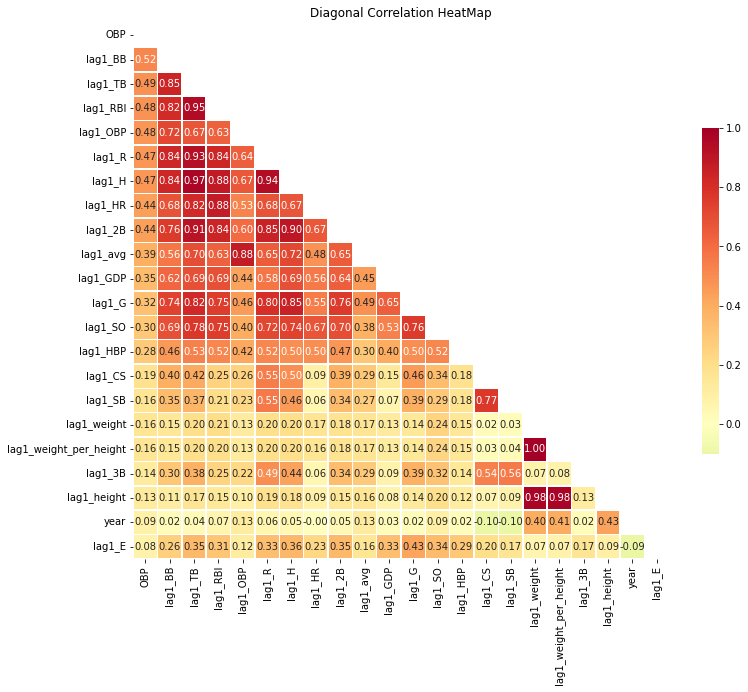

In [113]:
# 시간변수 생성 함수를 통한 지표별 1년 전 성적 추출
for col in numeric_cols:
    regular_season_temp = lag_function(regular_season_temp, col, 1)

numeric_cols.remove('OBP')
regular_season_temp.drop(numeric_cols, axis = 1, inplace= True)

# 상관관계 도출
corr_matrix = regular_season_temp.corr()
corr_matrix = corr_matrix.sort_values(by = 'OBP', axis = 0, ascending=False)
corr_matrix = corr_matrix[corr_matrix.index]

# 상관관계의 시각적 표현
f, ax = plt.subplots(figsize=(12, 12))
corr = regular_season_temp.select_dtypes(exclude=["object","bool"]).corr()

# 대각 행렬을 기준으로 한 쪽만 나타나게 설정해줍니다.
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

g = sns.heatmap(corr_matrix, cmap='RdYlGn_r', vmax= 1, mask=mask, 
center=0, annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Diagonal Correlation HeatMap")

희생 플라이 : 야구 타격의 일종

In [114]:
# 희생 플라이 구하기
#OBP(출루율) 계산 공식 이용하여 SF(희생 플라이)계산 >> (H+BB+HBP)/OBP-(AB+BB+HBP)
regular_season_df['SF'] = \
    regular_season_df[['H','BB','HBP']].sum(axis=1) / regular_season_df['OBP'] - \
    regular_season_df[['AB','BB','HBP']].sum(axis=1)
regular_season_df['SF'].fillna(0, inplace = True)
regular_season_df['SF'] = regular_season_df['SF'].apply(lambda x : round(x,0))

#한 타수당 평균 희생 플라이 계산 후 필요한 것만 추출
regular_season_df['SF_1'] = regular_season_df['SF'] / regular_season_df['AB']
regular_season_df_SF = regular_season_df[['batter_name','year','SF_1']]
regular_season_df_SF

,batter_name,year,SF_1
0,가르시아,2018,0.032787
1,강경학,2011,0.000000
2,강경학,2014,-0.000000
3,강경학,2015,0.009646
4,강경학,2016,0.009901
...,...,...,...
2442,황진수,2014,0.000000
2443,황진수,2015,0.000000
2444,황진수,2016,0.000000
2445,황진수,2017,0.008547


In [115]:
day_by_day_df.loc[day_by_day_df['date'] <= 7.18].groupby(
    ['batter_name','year'])['AB','H','BB','HBP'].sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


AB   H  BB  HBP
batter_name year                  
가르시아        2018   85  31   6    4
강경학         2011    1   0   0    0
            2014    0   0   2    0
            2015  156  39  21    2
            2016   81  12   6    2
...               ...  ..  ..  ...
황진수         2012    4   1   1    0
            2013    0   0   0    0
            2016    9   0   0    0
            2017   71  18   5    2
            2018   24   4   2    0

[1386 rows x 4 columns]

In [117]:
#day_by_day에서 연도별 선수의 시즌 전반기 출루율과 관련된 성적 합 구하기
sum_hf_yr_OBP = day_by_day_df.loc[day_by_day_df['date'] <= 7.18].groupby(
    ['batter_name','year'])['AB','H','BB','HBP'].sum().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [118]:
sum_hf_yr_OBP.merge(regular_season_df_SF, how = 'left',
                                    on=['batter_name','year'])

,batter_name,year,AB,H,BB,HBP,SF_1
0,가르시아,2018,85,31,6,4,0.032787
1,강경학,2011,1,0,0,0,0.000000
2,강경학,2014,0,0,2,0,-0.000000
3,강경학,2015,156,39,21,2,0.009646
4,강경학,2016,81,12,6,2,0.009901
...,...,...,...,...,...,...,...
1381,황진수,2012,4,1,1,0,-0.000000
1382,황진수,2013,0,0,0,0,NaN
1383,황진수,2016,9,0,0,0,0.000000
1384,황진수,2017,71,18,5,2,0.008547


In [119]:
#day_by_day와 regular season에서 구한 희생 플라이 관련 데이터를 합치기
sum_hf_yr_OBP = sum_hf_yr_OBP.merge(regular_season_df_SF, how = 'left',
                                    on=['batter_name','year'])

In [120]:
#선수별 전반기 희생 플라이 수 계산
sum_hf_yr_OBP['SF'] = (sum_hf_yr_OBP['SF_1']*sum_hf_yr_OBP['AB']).apply(
    lambda x: round(x, 0))
sum_hf_yr_OBP.drop('SF_1', axis = 1, inplace = True)

#선수별 전반기 OBP(출루율) 계산
sum_hf_yr_OBP['OBP'] = sum_hf_yr_OBP[['H', 'BB', 'HBP']].sum(axis = 1) / \
                       sum_hf_yr_OBP[['AB', 'BB', 'HBP','SF']].sum(axis = 1)
# OBP 결측치를 0으로 처리 
sum_hf_yr_OBP['OBP'].fillna(0, inplace = True)

# 분석에 필요하지 않은 열 제거
sum_hf_yr_OBP = sum_hf_yr_OBP[['batter_name','year','AB','OBP']]
sum_hf_yr_OBP

,batter_name,year,AB,OBP
0,가르시아,2018,85,0.418367
1,강경학,2011,1,0.000000
2,강경학,2014,0,1.000000
3,강경학,2015,156,0.342541
4,강경학,2016,81,0.222222
...,...,...,...,...
1381,황진수,2012,4,0.400000
1382,황진수,2013,0,0.000000
1383,황진수,2016,9,0.000000
1384,황진수,2017,71,0.316456


# 1.3.4. 추가 변수 생성

나이별 평균 성적

In [122]:
regular_season_df['year_born']

0       1985년 04월 12일
1       1992년 08월 11일
2       1992년 08월 11일
3       1992년 08월 11일
4       1992년 08월 11일
            ...      
2442    1989년 02월 15일
2443    1989년 02월 15일
2444    1989년 02월 15일
2445    1989년 02월 15일
2446    1989년 02월 15일
Name: year_born, Length: 2447, dtype: object

In [125]:
# x의 앞 4글자 가져옴
regular_season_df['year_born'].apply(lambda x: int(x[:4]))

0       1985
1       1992
2       1992
3       1992
4       1992
        ... 
2442    1989
2443    1989
2444    1989
2445    1989
2446    1989
Name: year_born, Length: 2447, dtype: int64

In [126]:
# 나이 변수 생성
regular_season_df['age'] = regular_season_df['year'] - \
                           regular_season_df['year_born'].apply(lambda x: int(x[:4]))

In [129]:
# agg 집계연산
regular_season_df.loc[regular_season_df['AB'] >= 30].groupby('age').agg({'OBP':['mean','median']})

OBP          
         mean    median
age                    
18   0.295750  0.314000
19   0.296261  0.295500
20   0.309184  0.327000
21   0.320382  0.320500
22   0.327844  0.323000
23   0.310377  0.316000
24   0.318427  0.320727
25   0.324182  0.322034
26   0.333186  0.337000
27   0.347202  0.357000
28   0.338325  0.348101
29   0.339798  0.335285
30   0.345746  0.346696
31   0.353535  0.358000
32   0.346149  0.353000
33   0.352323  0.352056
34   0.350241  0.354852
35   0.343182  0.333333
36   0.349309  0.360825
37   0.351053  0.362012
38   0.338510  0.353037
39   0.320446  0.333333
40   0.316836  0.312500
41   0.310056  0.346699

In [130]:
# 나이, 평균 출루율, 출루율 중위값으로 구성된 데이터프레임 구축
temp_df = regular_season_df.loc[regular_season_df['AB'] >= 30].groupby('age').agg(
    {'OBP':['mean','median']}).reset_index()

In [132]:
temp_df.columns

MultiIndex([('age',       ''),
            ('OBP',   'mean'),
            ('OBP', 'median')],
           )

In [133]:
temp_df.columns.droplevel() # 방법 : 멀티인덱스 다루는 방법

Index(['', 'mean', 'median'], dtype='object')

In [134]:
temp_df.columns = temp_df.columns.droplevel()
temp_df.columns = ['age', 'mean_OBP', 'median_OBP'] # 그냥 합쳐서 넣어준다.
temp_df.columns

Index(['age', 'mean_OBP', 'median_OBP'], dtype='object')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45208 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_te

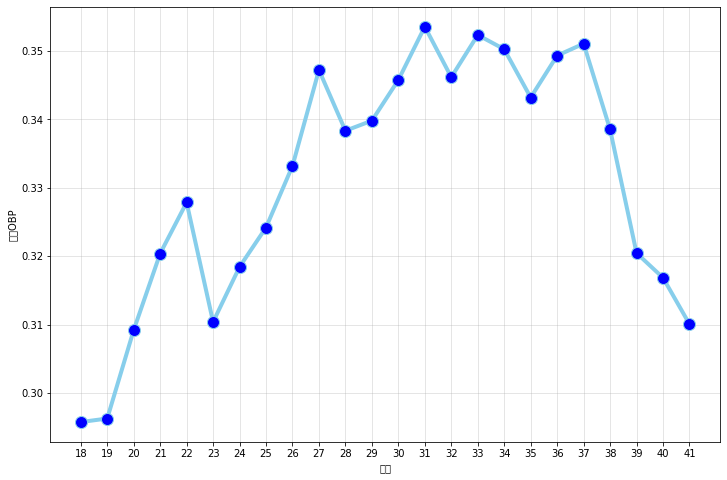

In [136]:
# 나이에 따른 출루율 추이 시각화
plt.figure(figsize=(12,8))
plt.plot('age', 'mean_OBP', data=temp_df, marker='o', markerfacecolor='blue',
         markersize=12, color='skyblue', linewidth=4)
plt.xticks(temp_df['age']) # 나이 표시
plt.grid(linestyle='-', alpha=0.4)
plt.ylabel('평균OBP')
plt.xlabel('나이')
plt.show()

In [137]:
sum_hf_yr_OBP

,batter_name,year,AB,OBP
0,가르시아,2018,85,0.418367
1,강경학,2011,1,0.000000
2,강경학,2014,0,1.000000
3,강경학,2015,156,0.342541
4,강경학,2016,81,0.222222
...,...,...,...,...
1381,황진수,2012,4,0.400000
1382,황진수,2013,0,0.000000
1383,황진수,2016,9,0.000000
1384,황진수,2017,71,0.316456


In [138]:
# 나이를 포함한 변수 선택
sum_hf_yr_OBP = sum_hf_yr_OBP.merge(regular_season_df[['batter_name','year','age']],
                                    how = 'left', on=['batter_name','year'])

# 시간변수 활용
# 총 3년 전 성적까지 변수를 생성
sum_hf_yr_OBP = lag_function(sum_hf_yr_OBP, "OBP", 1)
sum_hf_yr_OBP = lag_function(sum_hf_yr_OBP, "OBP", 2)
sum_hf_yr_OBP = lag_function(sum_hf_yr_OBP, "OBP", 3)
sum_hf_yr_OBP

,batter_name,year,AB,OBP,age,lag1_OBP,lag2_OBP,lag3_OBP
0,가르시아,2018,85,0.418367,33,NaN,NaN,NaN
1,강경학,2011,1,0.000000,19,NaN,NaN,NaN
2,강경학,2014,0,1.000000,22,NaN,NaN,NaN
3,강경학,2015,156,0.342541,23,NaN,NaN,NaN
4,강경학,2016,81,0.222222,24,0.342541,NaN,NaN
...,...,...,...,...,...,...,...,...
1381,황진수,2012,4,0.400000,23,NaN,NaN,NaN
1382,황진수,2013,0,0.000000,24,NaN,NaN,NaN
1383,황진수,2016,9,0.000000,27,NaN,NaN,NaN
1384,황진수,2017,71,0.316456,28,NaN,NaN,NaN


# 1.3.5. 데이터 사후 처리

In [141]:
sum_hf_yr_OBP[['lag1_OBP','lag2_OBP','lag3_OBP']].isna().sum()

lag1_OBP    569
lag2_OBP    749
lag3_OBP    843
dtype: int64

In [139]:
sum_hf_yr_OBP.shape[0]

1386

In [142]:
# 결측치 비율
round(sum_hf_yr_OBP[['lag1_OBP','lag2_OBP','lag3_OBP']].isna().sum() / \
      sum_hf_yr_OBP.shape[0], 2)

lag1_OBP    0.41
lag2_OBP    0.54
lag3_OBP    0.61
dtype: float64

In [143]:
regular_season_df.loc[regular_season_df['AB'] >= 30].groupby(
    'batter_name')['AB','H','BB','HBP','SF'].sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,AB,H,BB,HBP,SF
batter_name,,,,,
가르시아,183,62,9,8,6.0
강경학,827,201,107,14,5.0
강민호,5275,1460,569,128,50.0
강백호,527,153,52,3,2.0
강병식,1288,305,163,32,0.0
...,...,...,...,...,...
황선일,72,13,8,2,0.0
황윤호,57,9,0,3,0.0
황재균,4691,1348,434,49,50.0


In [145]:
#1. 선수별 OBP 평균
# SF = (H+BB+HBP) / OBP-(AB+BB+HBP)
# OBP = (H+BB+HBP) / (AB+BB+HBP+SF)
player_OBP_mean = regular_season_df.loc[regular_season_df['AB'] >= 30].groupby(
    'batter_name')['AB','H','BB','HBP','SF'].sum().reset_index()
player_OBP_mean['mean_OBP'] = player_OBP_mean[['H', 'BB', 'HBP']].sum(axis=1) / \
                            player_OBP_mean[['AB','BB','HBP','SF']].sum(axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [146]:
#2. 시즌별 OBP 평균
season_OBP_mean = regular_season_df.loc[regular_season_df['AB'] >= 30].groupby(
    'year')['AB','H','BB','HBP','SF'].sum().reset_index()
season_OBP_mean['mean_OBP'] = season_OBP_mean[['H', 'BB', 'HBP']].sum(axis=1) / \
                              season_OBP_mean[['AB','BB','HBP','SF']].sum(axis=1)
season_OBP_mean = season_OBP_mean[['year', 'mean_OBP']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [147]:
#### player_OBP_mean(선수평균) 열 추가
sum_hf_yr_OBP = sum_hf_yr_OBP.merge(player_OBP_mean[['batter_name', 'mean_OBP']],
                                    how ='left', on="batter_name")
sum_hf_yr_OBP = \
    sum_hf_yr_OBP.loc[~sum_hf_yr_OBP['mean_OBP'].isna()].reset_index(drop=True)
sum_hf_yr_OBP

,batter_name,year,AB,OBP,age,lag1_OBP,lag2_OBP,lag3_OBP,mean_OBP
0,가르시아,2018,85,0.418367,33,NaN,NaN,NaN,0.383495
1,강경학,2011,1,0.000000,19,NaN,NaN,NaN,0.337880
2,강경학,2014,0,1.000000,22,NaN,NaN,NaN,0.337880
3,강경학,2015,156,0.342541,23,NaN,NaN,NaN,0.337880
4,강경학,2016,81,0.222222,24,0.342541,NaN,NaN,0.337880
...,...,...,...,...,...,...,...,...,...
1347,황진수,2012,4,0.400000,23,NaN,NaN,NaN,0.358779
1348,황진수,2013,0,0.000000,24,NaN,NaN,NaN,0.358779
1349,황진수,2016,9,0.000000,27,NaN,NaN,NaN,0.358779
1350,황진수,2017,71,0.316456,28,NaN,NaN,NaN,0.358779


In [149]:
# 이 부분도 모르겠다..
# 결측치 처리하는 함수 정의
def lag_na_fill(data_set, var_name, past, season_var_mean_data):
    # data_Set: 이용할 데이터셋
    # var_name: 시간 변수를 만들 변수 이름
    # past: 몇 년 전 변수를 만들지 결정
    # season_var_name_mean_data season별로 var_name의 평균을 구한 데이터
  
    for i in range(0,len(data_set)):
        if np.isnan(data_set["lag"+str(past)+"_"+var_name][i]): # 어떤 형식으로 나올까?
            data_set.loc[i,["lag"+str(past)+"_"+var_name]] = (
                data_set["mean" + "_" + var_name][i] + season_var_mean_data.loc[
                    season_var_mean_data['year'] == (data_set['year'][i] - past),
                    "mean_" + var_name].iloc[0]
                ) / 2
    return data_set

In [150]:
# 생성한 함수를 이용해 결측치 처리 진행
sum_hf_yr_OBP = lag_na_fill(sum_hf_yr_OBP, "OBP", 1, season_OBP_mean) # 1년 전 성적 대체
sum_hf_yr_OBP = lag_na_fill(sum_hf_yr_OBP, "OBP", 2, season_OBP_mean) # 2년 전 성적 대체
sum_hf_yr_OBP = lag_na_fill(sum_hf_yr_OBP, "OBP", 3, season_OBP_mean) # 3년 전 성적 대체
sum_hf_yr_OBP

,batter_name,year,AB,OBP,age,lag1_OBP,lag2_OBP,lag3_OBP,mean_OBP
0,가르시아,2018,85,0.418367,33,0.369982,0.375910,0.373119,0.383495
1,강경학,2011,1,0.000000,19,0.347434,0.348603,0.344259,0.337880
2,강경학,2014,0,1.000000,22,0.346682,0.337511,0.343131,0.337880
3,강경학,2015,156,0.342541,23,0.353425,0.346682,0.337511,0.337880
4,강경학,2016,81,0.222222,24,0.342541,0.353425,0.346682,0.337880
...,...,...,...,...,...,...,...,...,...
1347,황진수,2012,4,0.400000,23,0.353580,0.357883,0.359052,0.358779
1348,황진수,2013,0,0.000000,24,0.347960,0.353580,0.357883,0.358779
1349,황진수,2016,9,0.000000,27,0.360760,0.363874,0.357131,0.358779
1350,황진수,2017,71,0.316456,28,0.363552,0.360760,0.363874,0.358779


### 1.3.6. SLG 데이터 전처리

Text(0.5, 1.0, 'Diagonal Correlation HeatMap')

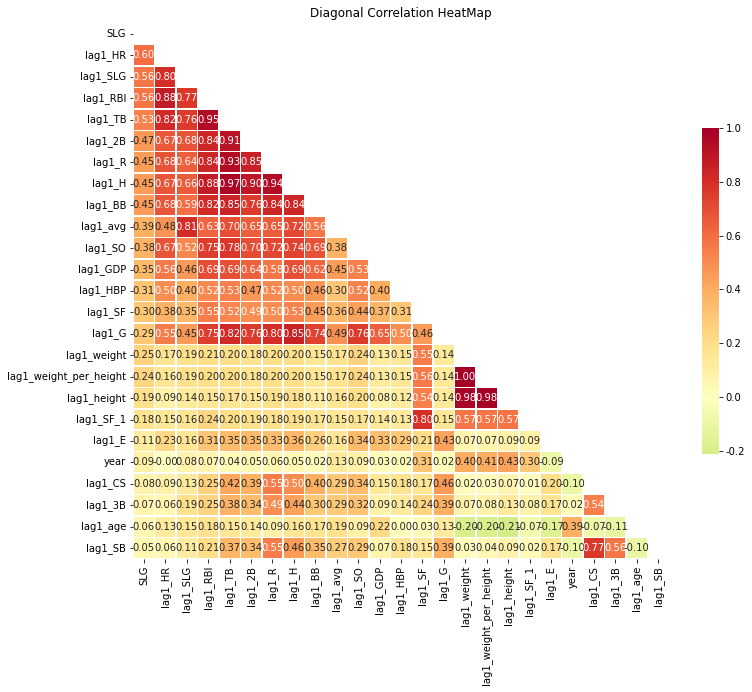

In [152]:
# 위 OBP 처리와 유사
# 상관관계를 탐색할 변수 선택
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = list(regular_season_df.select_dtypes(include=numerics).drop(
    ['batter_id','year','OPS','OBP'], axis =1).columns)
regular_season_temp = regular_season_df[numeric_cols + ['year', 'batter_name']].copy()
regular_season_temp = regular_season_temp.loc[regular_season_temp['AB']>=30]

# 시간변수 생성 함수를 통한 지표별 1년 전 성적 추출
for col in numeric_cols:
    regular_season_temp = lag_function(regular_season_temp, col, 1)

numeric_cols.remove('SLG')
regular_season_temp.drop(numeric_cols, axis = 1, inplace=True)

# 상관관계 도출
corr_matrix = regular_season_temp.corr()
corr_matrix = corr_matrix.sort_values(by = 'SLG', axis = 0, ascending=False)
corr_matrix = corr_matrix[corr_matrix.index]

# 상관관계의 시각적 표현
f, ax = plt.subplots(figsize=(12, 12))
corr = regular_season_temp.select_dtypes(exclude=["object","bool"]).corr()

# 대각 행렬을 기준으로 한쪽만 나타나게 설정해줍니다.
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)
g = sns.heatmap(corr_matrix, cmap='RdYlGn_r', vmax=1, mask=mask, center=0, annot=True,
                fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Diagonal Correlation HeatMap")

In [154]:
# 질문 왜 7월 18일 이후만 다루지?
day_by_day_df.loc[day_by_day_df['date'] > 7.18].groupby(
    ['batter_name','year'])['AB','H','2B','3B', 'HR'].sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


AB   H  2B  3B  HR
batter_name year                     
가르시아        2018   98  31   5   0   4
강경학         2014   86  19   2   3   1
            2015  155  41   2   3   0
            2016   20   4   2   1   0
            2017    2   1   0   0   0
...               ...  ..  ..  ..  ..
황진수         2012   14   1   0   0   0
            2014    5   0   0   0   0
            2015    2   0   0   0   0
            2016    1   0   0   0   0
            2017   46  16   0   1   1

[1413 rows x 5 columns]

In [153]:
# day_by_day에서 연도별 선수의 시즌 전반기 장타율(SLG)과 관련된 성적 합 구하기
sum_hf_yr_SLG = day_by_day_df.loc[day_by_day_df['date'] <= 7.18].groupby(
    ['batter_name','year'])['AB','H','2B','3B', 'HR'].sum().reset_index()

# 전반기 장타율 계산
sum_hf_yr_SLG['SLG'] = \
    (sum_hf_yr_SLG['H'] - sum_hf_yr_SLG[['2B', '3B', 'HR']].sum(axis=1) +
     sum_hf_yr_SLG['2B']*2 + sum_hf_yr_SLG['3B']*3 + sum_hf_yr_SLG['HR']*4
     ) / sum_hf_yr_SLG['AB']

# SLG 결측치를 0으로 처리 
sum_hf_yr_SLG['SLG'].fillna(0, inplace=True)

# 필요한 칼럼만 불러오고 나이 계산
sum_hf_yr_SLG = sum_hf_yr_SLG[['batter_name','year','AB','SLG']]
sum_hf_yr_SLG = sum_hf_yr_SLG.merge(regular_season_df[['batter_name','year','age']],
                                    how='left', on=['batter_name','year'])
sum_hf_yr_SLG.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,batter_name,year,AB,SLG,age
0,가르시아,2018,85,0.552941,33
1,강경학,2011,1,0.000000,19
2,강경학,2014,0,0.000000,22
3,강경학,2015,156,0.333333,23
4,강경학,2016,81,0.222222,24


In [155]:
# 총 3년 전 성적까지 변수를 생성
sum_hf_yr_SLG = lag_function(sum_hf_yr_SLG, "SLG", 1)
sum_hf_yr_SLG = lag_function(sum_hf_yr_SLG, "SLG", 2)
sum_hf_yr_SLG = lag_function(sum_hf_yr_SLG, "SLG", 3)
display(sum_hf_yr_SLG.head())

round(sum_hf_yr_SLG[['lag1_SLG', 'lag2_SLG', 'lag3_SLG']].isna().sum()/\
      sum_hf_yr_SLG.shape[0], 2)

,batter_name,year,AB,SLG,age,lag1_SLG,lag2_SLG,lag3_SLG
0,가르시아,2018,85,0.552941,33,NaN,NaN,NaN
1,강경학,2011,1,0.000000,19,NaN,NaN,NaN
2,강경학,2014,0,0.000000,22,NaN,NaN,NaN
3,강경학,2015,156,0.333333,23,NaN,NaN,NaN
4,강경학,2016,81,0.222222,24,0.333333,NaN,NaN


lag1_SLG    0.41
lag2_SLG    0.54
lag3_SLG    0.61
dtype: float64

In [156]:
# 선수별 SLG 평균 데이터(player_SLG_mean)를 만듭니다
player_SLG_mean = regular_season_df.loc[regular_season_df['AB'] >= 30].groupby(
    'batter_name')['AB','H','2B','3B','HR'].sum().reset_index()
player_SLG_mean['mean_SLG'] = \
    (player_SLG_mean['H'] - player_SLG_mean[['2B','3B','HR']].sum(axis = 1) +
     player_SLG_mean['2B']*2 + player_SLG_mean['3B']*3 + player_SLG_mean['HR']*4
    ) / player_SLG_mean['AB']
player_SLG_mean['mean_SLG']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


0      0.519126
1      0.332527
2      0.466540
3      0.523719
4      0.378106
         ...   
300    0.250000
301    0.175439
302    0.445960
303    0.282609
304    0.401709
Name: mean_SLG, Length: 305, dtype: float64

In [157]:
# 시즌별 SLG 평균 데이터(season_SLG_mean)를 만듭니다
season_SLG_mean = regular_season_df.loc[regular_season_df['AB'] >= 30].groupby(
    'year')['AB','H','2B','3B','HR'].sum().reset_index()
season_SLG_mean['mean_SLG'] = \
    (season_SLG_mean['H'] - season_SLG_mean[['2B','3B','HR']].sum(axis = 1) + 
     season_SLG_mean['2B']*2 + season_SLG_mean['3B']*3 + season_SLG_mean['HR']*4
    ) / season_SLG_mean['AB']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [158]:
# 선수 평균의 SLG(player_OBP_mean)를 새로운 변수로 더합니다.
sum_hf_yr_SLG = sum_hf_yr_SLG.merge(player_SLG_mean[['batter_name', 'mean_SLG']],
                                    how='left', on="batter_name")

# 선수 평균의 성적이 결측치이면 데이터에서 제거합니다.
sum_hf_yr_SLG = \
    sum_hf_yr_SLG.loc[~sum_hf_yr_SLG['mean_SLG'].isna()].reset_index(drop=True)

# 결측치 처리
sum_hf_yr_SLG = lag_na_fill(sum_hf_yr_SLG, "SLG", 1, season_SLG_mean) #1년전 성적 대체
sum_hf_yr_SLG = lag_na_fill(sum_hf_yr_SLG, "SLG", 2, season_SLG_mean) #2년전 성적 대체
sum_hf_yr_SLG = lag_na_fill(sum_hf_yr_SLG, "SLG", 3, season_SLG_mean) #3년전 성적 대체

display(sum_hf_yr_SLG.head())
round(sum_hf_yr_SLG[['lag1_SLG', 'lag2_SLG', 'lag3_SLG']].isna().sum()/\
      sum_hf_yr_SLG.shape[0], 2)

,batter_name,year,AB,SLG,age,lag1_SLG,lag2_SLG,lag3_SLG,mean_SLG
0,가르시아,2018,85,0.552941,33,0.481855,0.481498,0.476627,0.519126
1,강경학,2011,1,0.000000,19,0.372902,0.380882,0.361716,0.332527
2,강경학,2014,0,0.000000,22,0.362931,0.349344,0.359616,0.332527
3,강경학,2015,156,0.333333,23,0.389415,0.362931,0.349344,0.332527
4,강경학,2016,81,0.222222,24,0.333333,0.389415,0.362931,0.332527


lag1_SLG    0.0
lag2_SLG    0.0
lag3_SLG    0.0
dtype: float64